# Classificação de imagens com o conjunto de dados MedNIST

Introdução
Neste tutorial, apresentamos um exemplo de treinamento e avaliação de ponta a ponta com base no conjunto de dados MedNIST.
Passaremos pelos seguintes passos:

- Crie um conjunto de dados MONAI para treinamento e teste
- Use transformações MONAI para pré-processar dados
- Use o DenseNet do MONAI para a tarefa de classificação
- Treine o modelo com um programa PyTorch
- Avaliar no conjunto de dados de teste

### Obtenha o conjunto de dados
O conjunto de dados do MedNIST foi coletado de vários conjuntos do [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions), [o RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4) e o [conjunto de dados de raios-X do tórax do NIH](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).


Os comandos a seguir baixam e descompactam o conjunto de dados (~60 MB).

In [ ]:
!wget -q https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz

In [ ]:
# unzip the '.tar.gz' file to the current directory
import tarfile
datafile = tarfile.open("MedNIST.tar.gz")
datafile.extractall()
datafile.close()

#Instalando o MONAI

In [ ]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

     |████████████████████████████████| 943 kB 7.9 MB/s 
     |████████████████████████████████| 20.3 MB 1.3 MB/s 
     |████████████████████████████████| 16.6 MB 29.6 MB/s 
     |████████████████████████████████| 54.5 MB 22 kB/s 
     |████████████████████████████████| 15.0 MB 20.8 MB/s 
     |████████████████████████████████| 70.6 MB 8.7 kB/s 
     |████████████████████████████████| 95.3 MB 1.3 MB/s 


In [ ]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

print_config()

MONAI version: 0.10.dev2226
Numpy version: 1.21.6
Pytorch version: 1.11.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: f5def7f0f470cafc07dc8b13ea633dbaa2a22192
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.12.0+cu113
tqdm version: 4.64.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies




##Lendo nomes de arquivos de imagem das pastas do conjunto de dados
Antes de mais nada, verifica os arquivos do conjunto de dados e mostra algumas estatísticas. Existem 6 pastas no conjunto de dados: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT, que devem ser usadas como rótulos para treinar nosso modelo de classificação.

In [ ]:
data_dir = './MedNIST/'
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
                for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
image_width, image_height = Image.open(image_file_list[0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


## Visualizando alguns exemplos escolhidos aleatoriamente do conjunto de dados

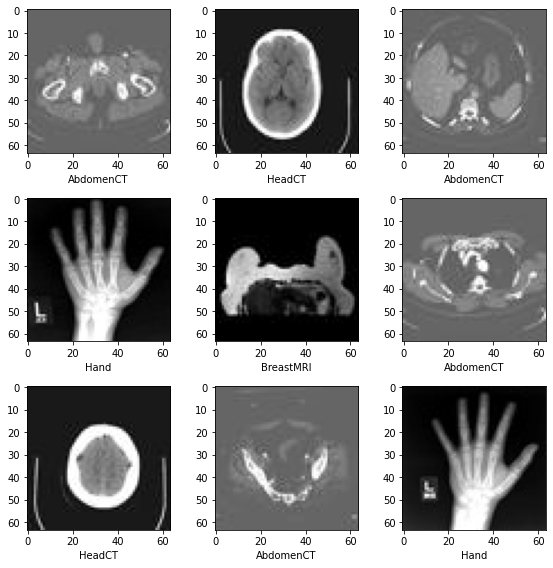

In [ ]:
plt.subplots(3, 3, figsize=(8, 8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Preparando listas de dados de treinamento, validação e teste
Selecionando aleatoriamente 10% do conjunto de dados como validação e 10% como teste.

In [ ]:
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))

Training count = 47189 Validation count = 5909 Test count = 5856


## Definir transformações MONAI, Dataset e Dataloader para pré-processar os  dados de teste.

In [ ]:
train_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    ToTensor()
])

val_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=True, n_classes=num_class)

`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.


In [ ]:
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=2)

test_ds = MedNISTDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=2)

## Definindo a rede e o otimizador
1. Definindo a taxa de aprendizado para o quanto o modelo é atualizado por lote.
2. Definindo o número de épocas total, pois misturamos sorteamos as transformações aleatórias, de modo que os dados de treinamento de cada época sejam diferentes.
E como este é apenas um tutorial de introdução, vamos treinar 4 épocas.
Se treinar 10 épocas, o modelo pode atingir 100% de precisão no conjunto de dados de teste.
3. Usando o DenseNet do MONAI e mude para o dispositivo GPU, este DenseNet pode suportar tarefas de classificação 2D e 3D.
4. Usando o otimizador Adam.

In [ ]:
device = torch.device("cuda:0")
model = DenseNet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=num_class
).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 4
val_interval = 1


## Treinamento do modelo
Executa um treinamento típico do PyTorch que roda o laço de época e laço de passo, e faz a validação após cada época.
Salvará os pesos do modelo para arquivo se chegar à melhor acurácia de validação.

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/157, train_loss: 1.8631
2/157, train_loss: 1.8183
3/157, train_loss: 1.8115
4/157, train_loss: 1.7817
5/157, train_loss: 1.7482
6/157, train_loss: 1.7211
7/157, train_loss: 1.7240
8/157, train_loss: 1.6857
9/157, train_loss: 1.6755
10/157, train_loss: 1.6509
11/157, train_loss: 1.6432
12/157, train_loss: 1.6125
13/157, train_loss: 1.5850
14/157, train_loss: 1.5747
15/157, train_loss: 1.5466
16/157, train_loss: 1.5301
17/157, train_loss: 1.4928
18/157, train_loss: 1.4878
19/157, train_loss: 1.4644
20/157, train_loss: 1.4479
21/157, train_loss: 1.4002
22/157, train_loss: 1.4177
23/157, train_loss: 1.4223
24/157, train_loss: 1.3804
25/157, train_loss: 1.3430
26/157, train_loss: 1.3416
27/157, train_loss: 1.3259
28/157, train_loss: 1.3711
29/157, train_loss: 1.3020
30/157, train_loss: 1.3127
31/157, train_loss: 1.2317
32/157, train_loss: 1.2533
33/157, train_loss: 1.2500
34/157, train_loss: 1.2233
35/157, train_loss: 1.1981
36/157, train_loss: 1.2497
37/157, train_lo

## Plotando a perda e a métrica

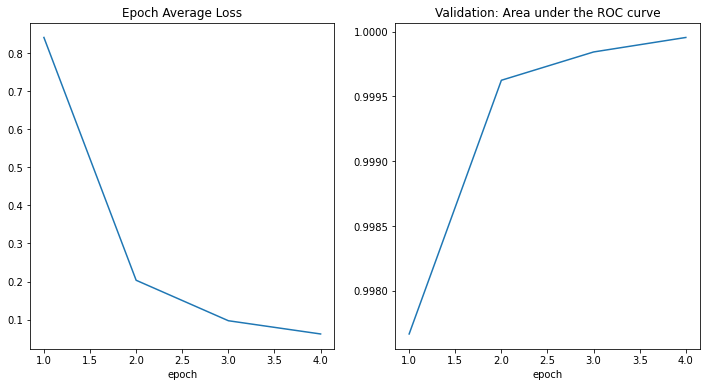

In [ ]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

## Avaliando o modelo na base de dados de teste
Após treinamento e validação, já temos o melhor modelo no teste de validação.
Precisamos validar o modelo na base de dados de teste para checar se o modelo está robusto e não há over-fitting.
Usaremos estas predições para gerar um relatório de classificação.

In [ ]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9910    0.9822    0.9866      1014
   BreastMRI     0.9978    0.9946    0.9962       924
         CXR     0.9990    0.9896    0.9943       965
     ChestCT     0.9960    1.0000    0.9980      1000
        Hand     0.9908    0.9948    0.9928       970
      HeadCT     0.9829    0.9959    0.9894       983

    accuracy                         0.9928      5856
   macro avg     0.9929    0.9929    0.9929      5856
weighted avg     0.9929    0.9928    0.9928      5856

